# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


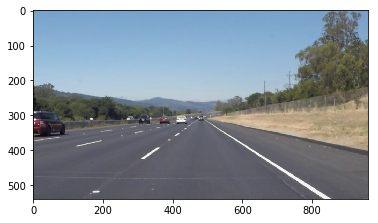

In [40]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [1]:
# NOTE! I have added some functions to these helpers to help my own 
# image pipeline further down in the notebook.

import math

def create_lane_lines_mask(img):
  """
  Returns a mask allowing orange and white lane lines, but
  blocking everything else. Values determined by trial and error
  for lane line detection.
  """
  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # Arrays are H-S-V, H ranges from 0-180, 
  # S and V range from 0-255
  orange_lower_bound_hsv = np.array([90,0,0])
  orange_upper_bound_hsv = np.array([100,255,255])
  orange_mask = cv2.inRange(img_hsv, orange_lower_bound_hsv, orange_upper_bound_hsv)

  white_lower_bound_hsv = np.array([0,0,230])
  white_upper_bound_hsv = np.array([180,255,255])
  white_mask = cv2.inRange(img_hsv, white_lower_bound_hsv, white_upper_bound_hsv)

  return orange_mask + white_mask

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_points(img, points, color=[255, 0, 0], radius=2, thickness=2):
    """
    Draws points on the provided `img`
    """
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), radius=radius, color=color, thickness=thickness)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def mean_locations_from_hough_lines(lines):
  """
  Returns the mean location of a line (represented by two pairs of points).  
  """
  locations = []
  for line in lines:
    (x1,y1,x2,y2) = line[0]
    locations.append(( int( (x1 + x2) / 2 ), int( (y1 + y2) / 2 )))
  return np.array(locations)

def intercepts_from_hough_lines(lines):
  """
  Returns the intercepts for a collection of Hough lines.

  Values with infinite slopes (vertical lines) are discarded.
  """
  intercepts = []
  for line in lines:
    (x1,y1,x2,y2) = line[0]
    if x2 - x1 == 0:
      continue
    m = (y2 - y1) / (x2 - x1)
    b = y2 - m * x2
    intercepts.append(b)
  return np.array(intercepts)

def slopes_from_hough_lines(lines):
  """
  Returns the slopes for a collection of Hough lines.
  
  Values with infinite slopes (vertical lines) are discarded.
  """
  slopes = []
  for line in lines:
    (x1,y1,x2,y2) = line[0]
    if x2 - x1 == 0:
      continue
    m = (y2 - y1) / (x2 - x1)
    slopes.append(m)
  return np.array(slopes)

def hough_lines_image(img, rho, theta, threshold, min_line_len, max_line_gap):
  """
  `img` should be the output of a Canny transform.
      
  Returns an image with hough lines drawn.
  """
  lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
  return image_with_lines_from_image(img, lines)

def image_with_points_from_image(img, points, color=[255, 0, 0], radius=2, thickness=2):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines provided in `lines` drawn.
    """
    points_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_points(points_img, points, color=color, radius=radius, thickness=thickness)
    return points_img

def image_with_lines_from_image(img, lines, color=[255, 0, 0], thickness=2):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines provided in `lines` drawn.
    """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, color=color, thickness=thickness)
    return line_img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns a collection of lines (shape (num_lines,1,4)) found using the Hough
    algorithm. 
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    filtered_lines = []
    for line in lines:
      (x1,y1,x2,y2) = line[0]
      if x2 - x1 == 0:
        continue
      filtered_lines.append([[x1,y1,x2,y2]])

    return filtered_lines

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [82]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Examples of Intermediate Steps

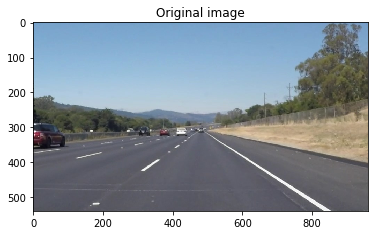

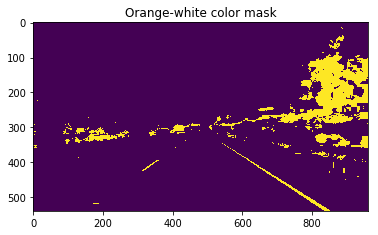

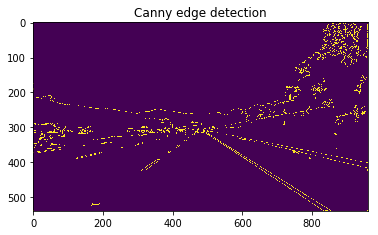

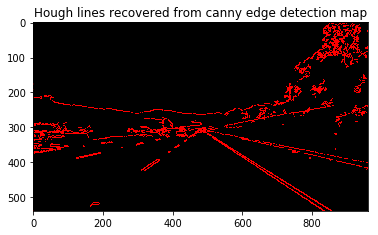

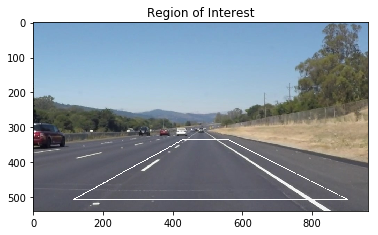

In [91]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

plt.figure()
plt.imshow(image)
plt.title('Original image')

plt.figure()
plt.imshow(create_lane_lines_mask(image))
plt.title('Orange-white color mask')

canny_image = canny(image, 1, 250)
plt.figure()
plt.imshow(canny_image)
plt.title('Canny edge detection')

plt.figure()
plt.imshow(hough_lines_image(canny_image, rho=1, theta=np.pi / 180, threshold=10, min_line_len=1, max_line_gap=1))
plt.title('Hough lines recovered from canny edge detection map')

plt.figure()
width = image.shape[1]
height = image.shape[0]
inclusion_region = np.array([[ \
    (0.12 * width, 0.94 * height), \
    (0.45 * width, 0.62 * height), \
    (0.58 * width, 0.62 * height), \
    (0.94 * width, 0.94 * height) \
]], dtype=np.int32)
r = inclusion_region[0]
region_lines = [ \
    [ (r[0][0],r[0][1],r[1][0],r[1][1]) ], \
    [ (r[1][0],r[1][1],r[2][0],r[2][1]) ], \
    [ (r[2][0],r[2][1],r[3][0],r[3][1]) ], \
    [ (r[3][0],r[3][1],r[0][0],r[0][1]) ], \
]
draw_lines(image, region_lines, color=[255,255,255])
plt.imshow(image)
plt.title('Region of Interest')

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

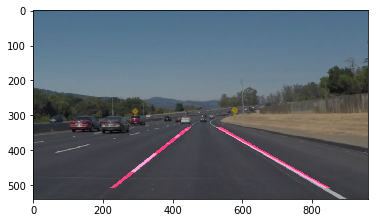

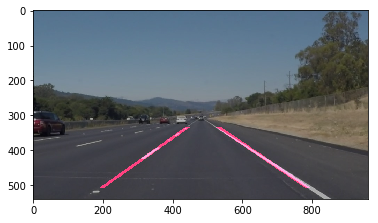

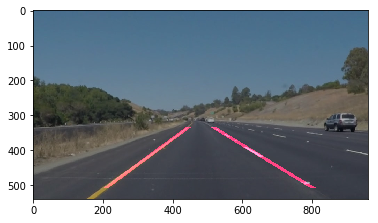

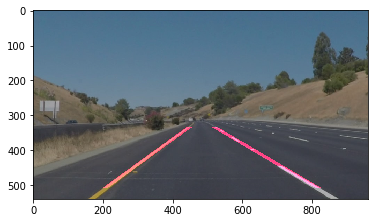

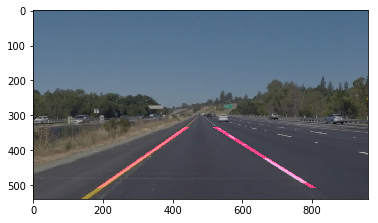

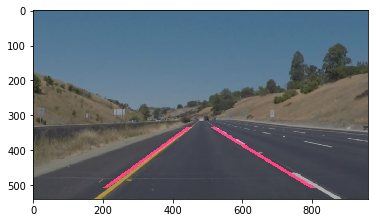

In [83]:
from copy import copy

# This is my main lane finding image pipeline, used both for the images in test_images as
# well as in the video processing pipeline below.
def process_image(image, show_region=False, show_hough_line_locations=False, line_color=[199,0,57]):
  original_image = copy(image)
  width = image.shape[1]
  height = image.shape[0]

  # A trapezoidal region to focus on. We exclude Hough lines
  # outside this region.
  inclusion_region = np.array([[ \
    (0.12 * width, 0.94 * height), \
    (0.45 * width, 0.62 * height), \
    (0.58 * width, 0.62 * height), \
    (0.94 * width, 0.94 * height) \
    ]], dtype=np.int32)

  r = inclusion_region[0]
  region_lines = [ \
    [ (r[0][0],r[0][1],r[1][0],r[1][1]) ], \
    [ (r[1][0],r[1][1],r[2][0],r[2][1]) ], \
    [ (r[2][0],r[2][1],r[3][0],r[3][1]) ], \
    [ (r[3][0],r[3][1],r[0][0],r[0][1]) ], \
  ]
  if show_region:
    draw_lines(original_image, region_lines, color=[255,255,255])

  # A color-based mask attempting to only include lane lines (orange and white).
  # Blurring this mask allows a bit of leniency in the application of the mask.
  lane_lines_mask = gaussian_blur(create_lane_lines_mask(image), kernel_size=3)

  image = gaussian_blur(image, kernel_size=3)

  # Parameters of the Canny edge detection and the Hough Line search were informed
  # by the preparation lessons from Udacity and tweaked to find effective values.
  image = canny(image, 1, 250)  
  lines = hough_lines(image, rho=1, theta=np.pi / 180, threshold=10, min_line_len=1, max_line_gap=1)

  mask = np.ones_like(image)
  mask = region_of_interest(mask, inclusion_region)

  slopes = slopes_from_hough_lines(lines)

  # We'll handle negative-sloped and positive-sloped detected lines separately to
  # isolate the left and right lane lines.
  parameter_sets = [ \
    { 
      "slope_indexes": np.where(slopes > 0), \
      "color": [255,0,0], \
      "mask_condition": lambda x,y,mask: mask[y][x] > 0 and x > 0.5 * width and lane_lines_mask[y][x] > 0,
      "slopes": positive_slopes,
      "intercepts": positive_intercepts,
    },
    { 
      "slope_indexes": np.where(slopes < 0), \
      "color": [0,0,255], \
      "mask_condition": lambda x,y,mask: mask[y][x] > 0 and x < 0.5 * width and lane_lines_mask[y][x] > 0,
      "slopes": negative_slopes,
      "intercepts": negative_intercepts,
    },
  ]

  annotation_images = []
  for parameters in parameter_sets:
    slope_indexes = parameters["slope_indexes"]
    color = parameters["color"]
    mask_condition = parameters["mask_condition"]
    running_slopes = parameters["slopes"]
    running_intercepts = parameters["intercepts"]

    # Use only positive- or negative-sloped Hough lines
    slopes = slopes_from_hough_lines(lines)[slope_indexes]
    intercepts = intercepts_from_hough_lines(lines)[slope_indexes]
    locations = mean_locations_from_hough_lines(lines)[slope_indexes]

    # Only include Hough lines that pass through our masks (trapezoidal region + HSV-based lane line mask)
    slopes = np.array([slope for (point, slope) in zip(locations, slopes) if mask_condition(point[0],point[1],mask) ])
    intercepts = np.array([intercept for (point, intercept) in zip(locations, intercepts) if mask_condition(point[0],point[1],mask) ])
    locations = np.array([point for point in locations if mask_condition(point[0],point[1],mask) ])

    if len(slopes) > 0 and len(intercepts) > 0:

      # Simple linear fit to the location of the accepted Hough lines
      m,b = np.polyfit([point[0] for point in locations], \
                       [point[1] for point in locations], \
                       deg=1)
      running_slopes.append(m)
      running_intercepts.append(b)

      # If we have enough data points, use a moving/running median
      if len(running_slopes) > 5:
        m = np.median(running_slopes[-5:])
        b = np.median(running_intercepts[-5:])

      f = lambda x: m * x + b

      # Draw Hough line locations (optional), and the final fitted lines.
      points_fraction = 1 if show_hough_line_locations else 0

      # Image of the locations of Hough lines
      points_image = image_with_points_from_image(image, locations, color=color)        

      # Final line image for either left or right lane line
      lines_image = image_with_lines_from_image(image, [ [(0, int(f(0)), width, int(f(width) ))] ], color=line_color, thickness=8)

      # Combined annotation images
      annotation_images.append(weighted_img(points_image, lines_image, α=1, β=points_fraction))

  # If we don't have any Hough lines that meet our criteria, exit early with the original image
  if len(annotation_images) < 2:
    return original_image

  # Combine left and right lane line annotations
  image = weighted_img(annotation_images[0], annotation_images[1], α=1, β=1)

  # Clip annotations to our region of interest
  image = region_of_interest(image, inclusion_region)

  # Final output image
  output_image = weighted_img(image, original_image, α=0.7, β=1)

  return output_image

# Keep track of slopes and intercepts to perform
# a moving average when we present the final lines.
positive_slopes = []
negative_slopes = []
positive_intercepts = []
negative_intercepts = []

for filename in os.listdir("test_images/"):    
  image = mpimg.imread('test_images/' + filename)
  processed_image = process_image(image)
  plt.figure()
  plt.imshow(processed_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
# See process_image defined in cells above.

Let's try the one with the solid white lane on the right first ...

In [84]:
# Keep track of slopes and intercepts to perform
# a moving average when we present the final lines.
positive_slopes = []
negative_slopes = []
positive_intercepts = []
negative_intercepts = []

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:11<00:00, 18.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 12.6 s, sys: 590 ms, total: 13.2 s
Wall time: 12.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [72]:
# Keep track of slopes and intercepts to perform
# a moving average when we present the final lines.
positive_slopes = []
negative_slopes = []
positive_intercepts = []
negative_intercepts = []

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:42<00:00, 17.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 43.4 s, sys: 1.81 s, total: 45.2 s
Wall time: 43.3 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [73]:
# Keep track of slopes and intercepts to perform
# a moving average when we present the final lines.
positive_slopes = []
negative_slopes = []
positive_intercepts = []
negative_intercepts = []

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [01:05<00:00,  5.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 4s, sys: 1.49 s, total: 1min 5s
Wall time: 1min 6s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))